<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=300, height=300></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде - "яблоки и груши":

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
data = pd.read_csv("./data/apples_pears.csv")

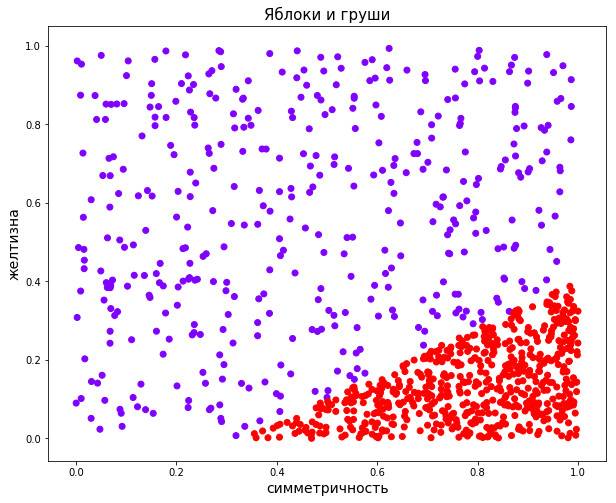

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [11]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [12]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);  ***

Рассмотрим второй путь (он чуть более user-friendly), к первому потом ещё вернёмся, и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [15]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [16]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [17]:
neuron(torch.autograd.Variable(torch.FloatTensor([1, 1])))

tensor([0.4644], grad_fn=<SigmoidBackward>)

Предскажем ещё необученным нейроном:

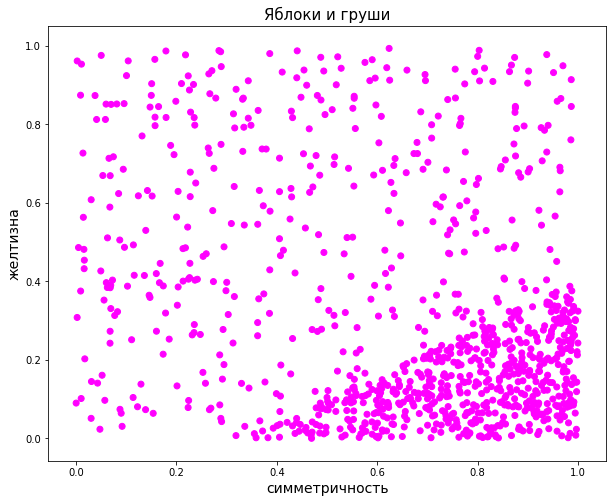

In [20]:
proba_pred = neuron(torch.autograd.Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [21]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [35]:
# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.01  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

C:\Users\Denis\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 36.76803207397461
1 36.724456787109375
2 36.680599212646484
3 36.637908935546875
4 36.59409713745117
5 36.54996871948242
6 36.506065368652344
7 36.4626350402832
8 36.419620513916016
9 36.37676239013672
10 36.333885192871094
11 36.29104995727539
12 36.24845504760742
13 36.206172943115234
14 36.16413879394531
15 36.122215270996094
16 36.08034133911133
17 36.03854751586914
18 35.996917724609375
19 35.95551300048828
20 35.914329528808594
21 35.87332534790039
22 35.83245086669922
23 35.79170608520508
24 35.75112533569336
25 35.71074676513672
26 35.67056655883789
27 35.630558013916016
28 35.5906867980957
29 35.55095672607422
30 35.51138687133789
31 35.47200012207031
32 35.43279266357422
33 35.39375686645508
34 35.35487365722656
35 35.31614303588867
36 35.27757263183594
37 35.23918151855469
38 35.20095443725586
39 35.16289138793945
40 35.124977111816406
41 35.087215423583984
42 35.04961395263672
43 35.012176513671875
44 34.97489929199219
45 34.93777084350586
46 34.90079879760742
47 34.86397

Обучили. Предскажем теперь:

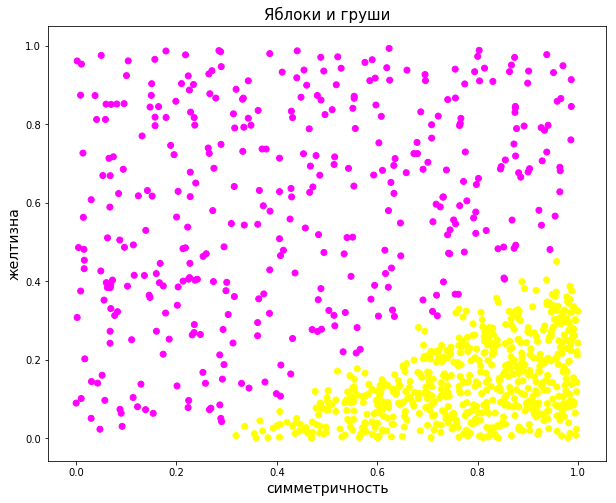

In [36]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

### Задача 1

1. Как видно по рисунку - качество не идеальное (даже перцептрон на нумпае лучше :). Добейтесь идеального качества (или очень близкого к идеальному), путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации);
2. Используйте функцию потерь `torch.nn.NLLLoss()` (== LogLoss) или `torch.nn.CrossEntropy()`, сделайте вывод о работе нейрона.

In [37]:
# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.01  #
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.Adam(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

C:\Users\Denis\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 25.454103469848633
1 25.43638801574707
2 25.418537139892578
3 25.401287078857422
4 25.383312225341797
5 25.36526107788086
6 25.34747886657715
7 25.329944610595703
8 25.31242561340332
9 25.294788360595703
10 25.277137756347656
11 25.259628295898438
12 25.242267608642578
13 25.22494125366211
14 25.207576751708984
15 25.190196990966797
16 25.17287254333496
17 25.155649185180664
18 25.138504028320312
19 25.121387481689453
20 25.104278564453125
21 25.08720588684082
22 25.07021141052246
23 25.05328941345215
24 25.036409378051758
25 25.019550323486328
26 25.002723693847656
27 24.98595428466797
28 24.969247817993164
29 24.952592849731445
30 24.93596839904785
31 24.919376373291016
32 24.9028377532959
33 24.886350631713867
34 24.869911193847656
35 24.853506088256836
36 24.837139129638672
37 24.82081413269043
38 24.80453872680664
39 24.788307189941406
40 24.77210807800293
41 24.75594711303711
42 24.73982810974121
43 24.723751068115234
44 24.70771598815918
45 24.691709518432617
46 24.67574310302

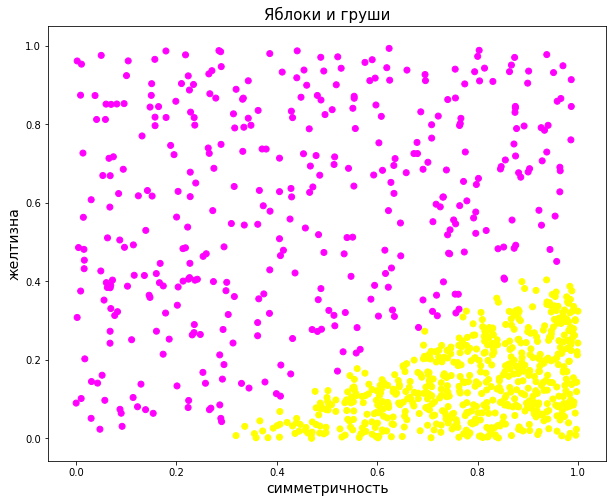

In [38]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

Круто. Нейрон работет, отличает яблоки от груш (Вы ведь этого добились, правда?). Но так ли он силён? Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

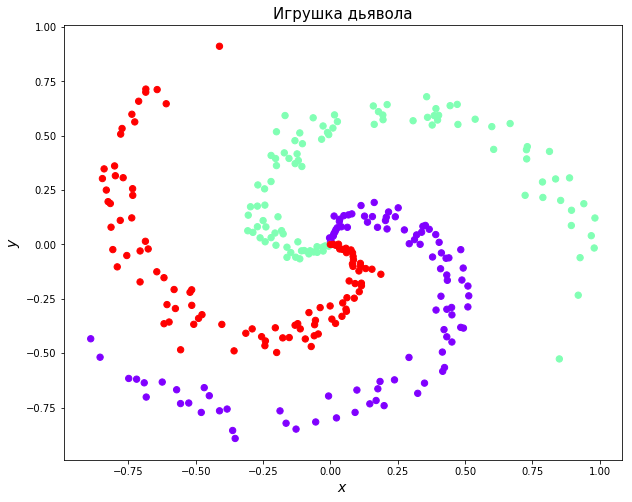

In [54]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear
import numpy as np

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable() (без этого градиенты не посчитать):

In [81]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [82]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


В атаку, наш славный нейрон с сигмоидой (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [83]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

loss_fn = torch.nn.NLLLoss(size_average=False)

learning_rate = 1e-3
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

C:\Users\Denis\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 -22.710397720336914
1 -55.60381317138672
2 -88.4971923828125
3 -121.39058685302734
4 -154.28404235839844
5 -187.17742919921875
6 -220.0707244873047
7 -252.9642333984375
8 -285.8575134277344
9 -318.75091552734375
10 -351.64447021484375
11 -384.5377197265625
12 -417.43109130859375
13 -450.3245849609375
14 -483.2179870605469
15 -516.111572265625
16 -549.0046997070312
17 -581.8981323242188
18 -614.7915649414062
19 -647.6844482421875
20 -680.5784301757812
21 -713.4715576171875
22 -746.3648681640625
23 -779.2586669921875
24 -812.1519165039062
25 -845.0454711914062
26 -877.9384155273438
27 -910.8318481445312
28 -943.72509765625
29 -976.6185302734375
30 -1009.5117797851562
31 -1042.4053955078125
32 -1075.299072265625
33 -1108.191650390625
34 -1141.08544921875
35 -1173.97900390625
36 -1206.872314453125
37 -1239.7655029296875
38 -1272.6595458984375
39 -1305.552490234375
40 -1338.4451904296875
41 -1371.3387451171875
42 -1404.2325439453125
43 -1437.126220703125
44 -1470.01953125
45 -1502.9127197

405 -13344.5224609375
406 -13377.421875
407 -13410.310546875
408 -13443.203125
409 -13476.10546875
410 -13508.98828125
411 -13541.8779296875
412 -13574.76953125
413 -13607.6669921875
414 -13640.55859375
415 -13673.4560546875
416 -13706.3486328125
417 -13739.240234375
418 -13772.1376953125
419 -13805.0224609375
420 -13837.91796875
421 -13870.81640625
422 -13903.70703125
423 -13936.5986328125
424 -13969.4853515625
425 -14002.3837890625
426 -14035.2734375
427 -14068.1640625
428 -14101.056640625
429 -14133.9501953125
430 -14166.8427734375
431 -14199.73828125
432 -14232.6318359375
433 -14265.52734375
434 -14298.41796875
435 -14331.3134765625
436 -14364.2080078125
437 -14397.1015625
438 -14429.9892578125
439 -14462.8818359375
440 -14495.76953125
441 -14528.6708984375
442 -14561.5625
443 -14594.455078125
444 -14627.34765625
445 -14660.2421875
446 -14693.1318359375
447 -14726.0263671875
448 -14758.92578125
449 -14791.8095703125
450 -14824.708984375
451 -14857.5986328125
452 -14890.4921875
453 

In [78]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

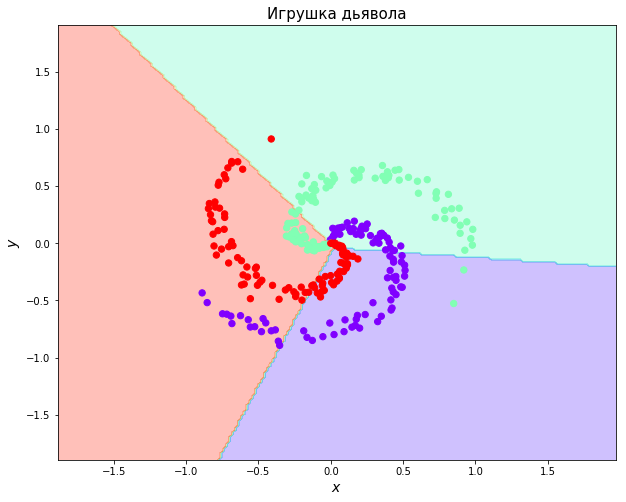

In [84]:
# Отрисовочна магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

---

### Задача 2

Меняя все известные Вам способы улучшения нейросети, постарайтесь добиться лучшего качества здесь. (**архитектуру менять нельзя**, мы же хотим добиться победы одним нейроном (слоем)).

In [0]:
# Поменял функцию ошибки, lr

---

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*